In [ ]:
from utils import load_crypto_dir, preprocess_ohlc, align_two
from trade import Exchange, CointBacktester
from plot import (
    plot_beta_and_pvalue,
    plot_equity_with_trades,
    plot_trade_residual_spread_paths,
    _trade_segments_from_daily,
    heatmap_from_results,
    heatmap_final_equity,
    heatmap_success_rate,
    heatmap_entry_count,
)
from metrics import summarize_performance
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

In [ ]:
data_dir = "/home/jim/CryptoPairTrading/data/futures"
start_date = (datetime(2023, 1, 1) - timedelta(days=119)).strftime("%Y-%m-%d")
end_date = "2024-12-31"

df_dict = load_crypto_dir(data_dir, start_date=start_date, end_date=end_date)
sorted(df_dict.keys())

['1INCHUSDT_1h',
 'BANDUSDT_1h',
 'C98USDT_1h',
 'CELOUSDT_1h',
 'DOGEUSDT_1h',
 'DOTUSDT_1h',
 'KSMUSDT_1h',
 'MINAUSDT_1h',
 'OPUSDT_1h']

In [3]:
key1 = "KSMUSDT_1h"
key2 = "CELOUSDT_1h"

df1 = preprocess_ohlc(df_dict[key1])
df2 = preprocess_ohlc(df_dict[key2])

coint_var = "log_close"
merged_df = align_two(df1, df2, coint_var=coint_var)
merged_df.head()

,open_time,log_close_1,close_1,log_close_2,close_2
0,2022-09-04 00:00:00,3.891820,49.00,-0.189951,0.827
1,2022-09-04 01:00:00,3.893248,49.07,-0.191161,0.826
2,2022-09-04 02:00:00,3.897518,49.28,-0.186330,0.830
3,2022-09-04 03:00:00,3.892840,49.05,-0.187535,0.829
4,2022-09-04 04:00:00,3.897924,49.30,-0.186330,0.830


In [12]:
ex = Exchange(merged_df, coint_var=coint_var)

start = merged_df["open_time"].min()
end = merged_df["open_time"].max()

bt = CointBacktester(
    exchange=ex,
    start_time=start,
    end_time=end,
    coint_var=coint_var,
    train_len=120 * 24,  # window length in bars
    gap=24,  # decision cadence in bars
    pval_alpha=0.05,
    entry_k=2.0,
    exit_k=0.5,
    relaxed_pval_alpha=0.20,     # optional
    stop_k=1.5,                  # optional
    stop_loss_cooling_days=5.0,  # optional
    initial_balance=1_000_000.0,
    trade_frac=0.05,
    margin_rate=0.10,
    fee_rate=5e-4,
)

daily, fits = bt.run()
fits.head()

,fit_time,beta0,beta1_log,sigma_log,p_value,entry_allowed,train_start,train_end,valid_from_idx,valid_to_idx,reason,fixed_beta_p,fixed_beta_sigma,fixed_beta_thr,fixed_beta_train_start,fixed_beta_train_end
0,2023-01-02,3.981946,1.068738,0.077075,0.004046,True,2022-09-04 01:00:00,2023-01-02,2880,2903,periodic_decision,NaN,NaN,NaN,NaT,NaT
1,2023-01-03,3.979532,1.067772,0.076704,0.003519,True,2022-09-05 01:00:00,2023-01-03,2904,2927,periodic_decision,NaN,NaN,NaN,NaT,NaT
2,2023-01-04,3.976916,1.066402,0.076326,0.005369,True,2022-09-06 01:00:00,2023-01-04,2928,2951,periodic_decision,NaN,NaN,NaN,NaT,NaT
3,2023-01-05,3.974351,1.064292,0.076042,0.003302,True,2022-09-07 01:00:00,2023-01-05,2952,2975,periodic_decision,NaN,NaN,NaN,NaT,NaT
4,2023-01-06,3.971418,1.060654,0.075268,0.001781,True,2022-09-08 01:00:00,2023-01-06,2976,2999,periodic_decision,NaN,NaN,NaN,NaT,NaT


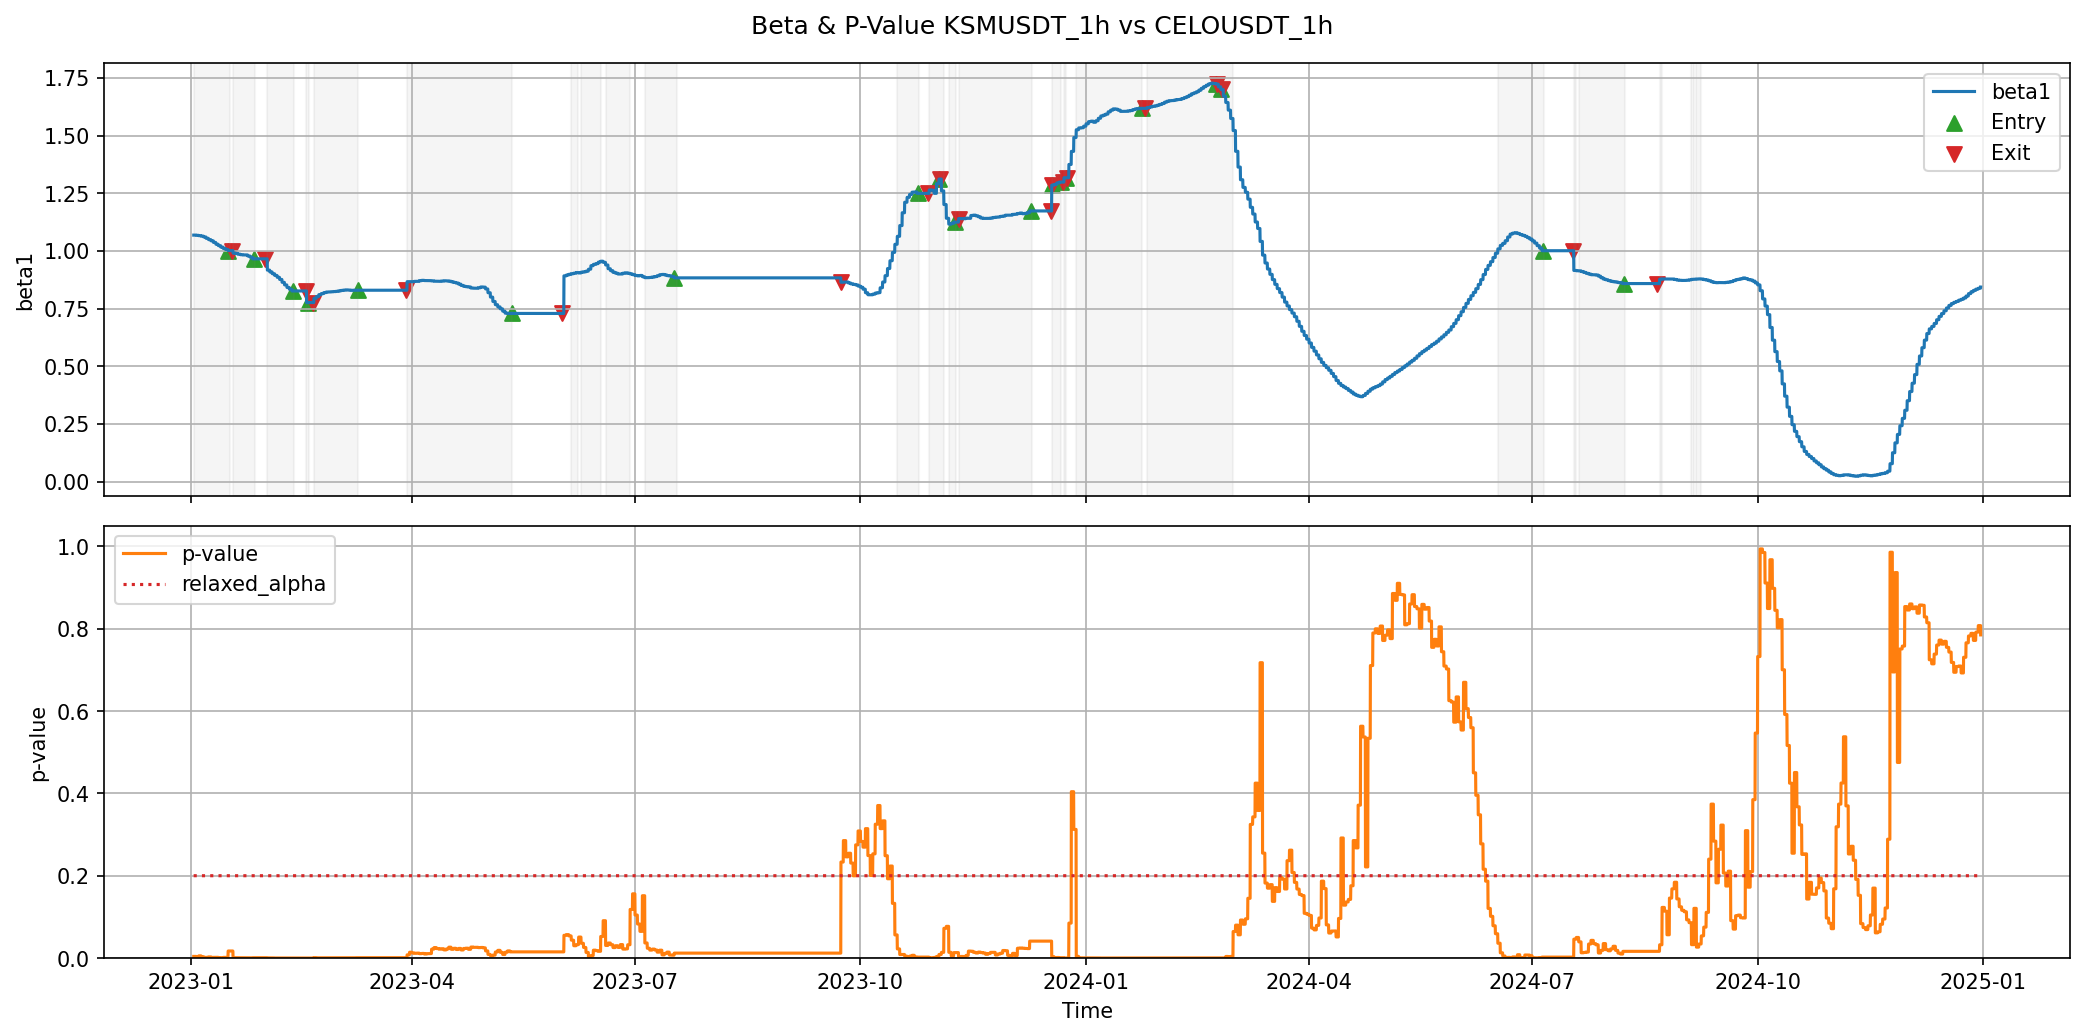

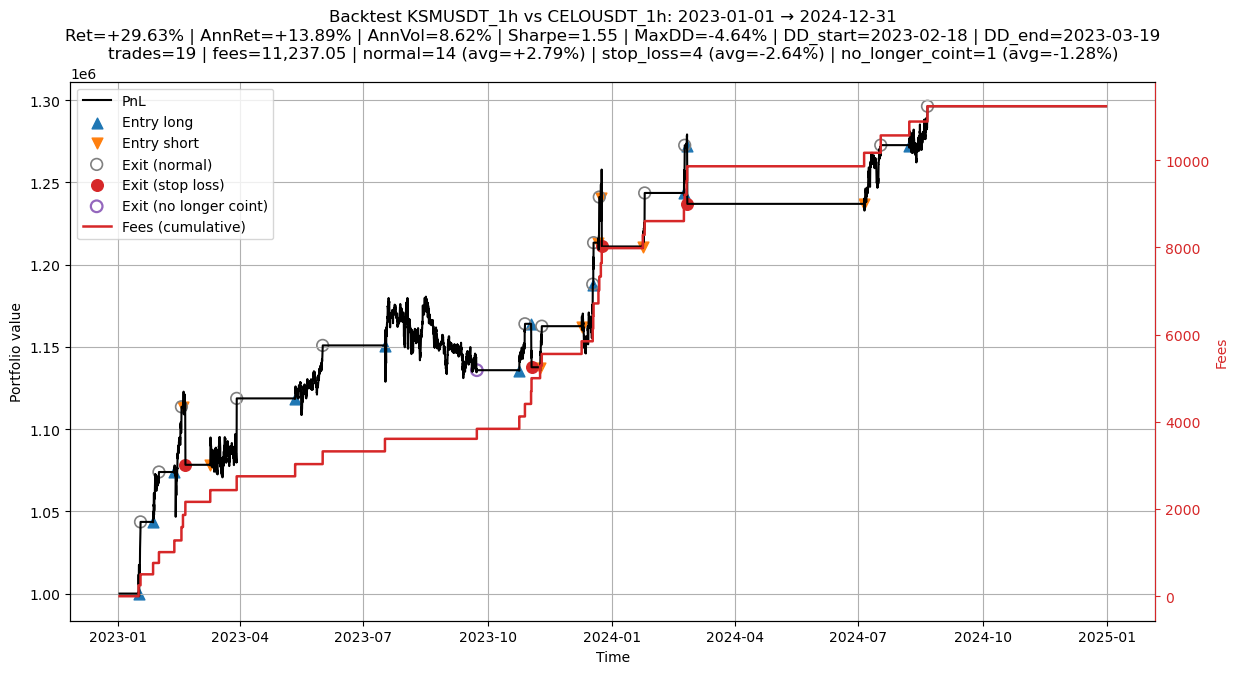

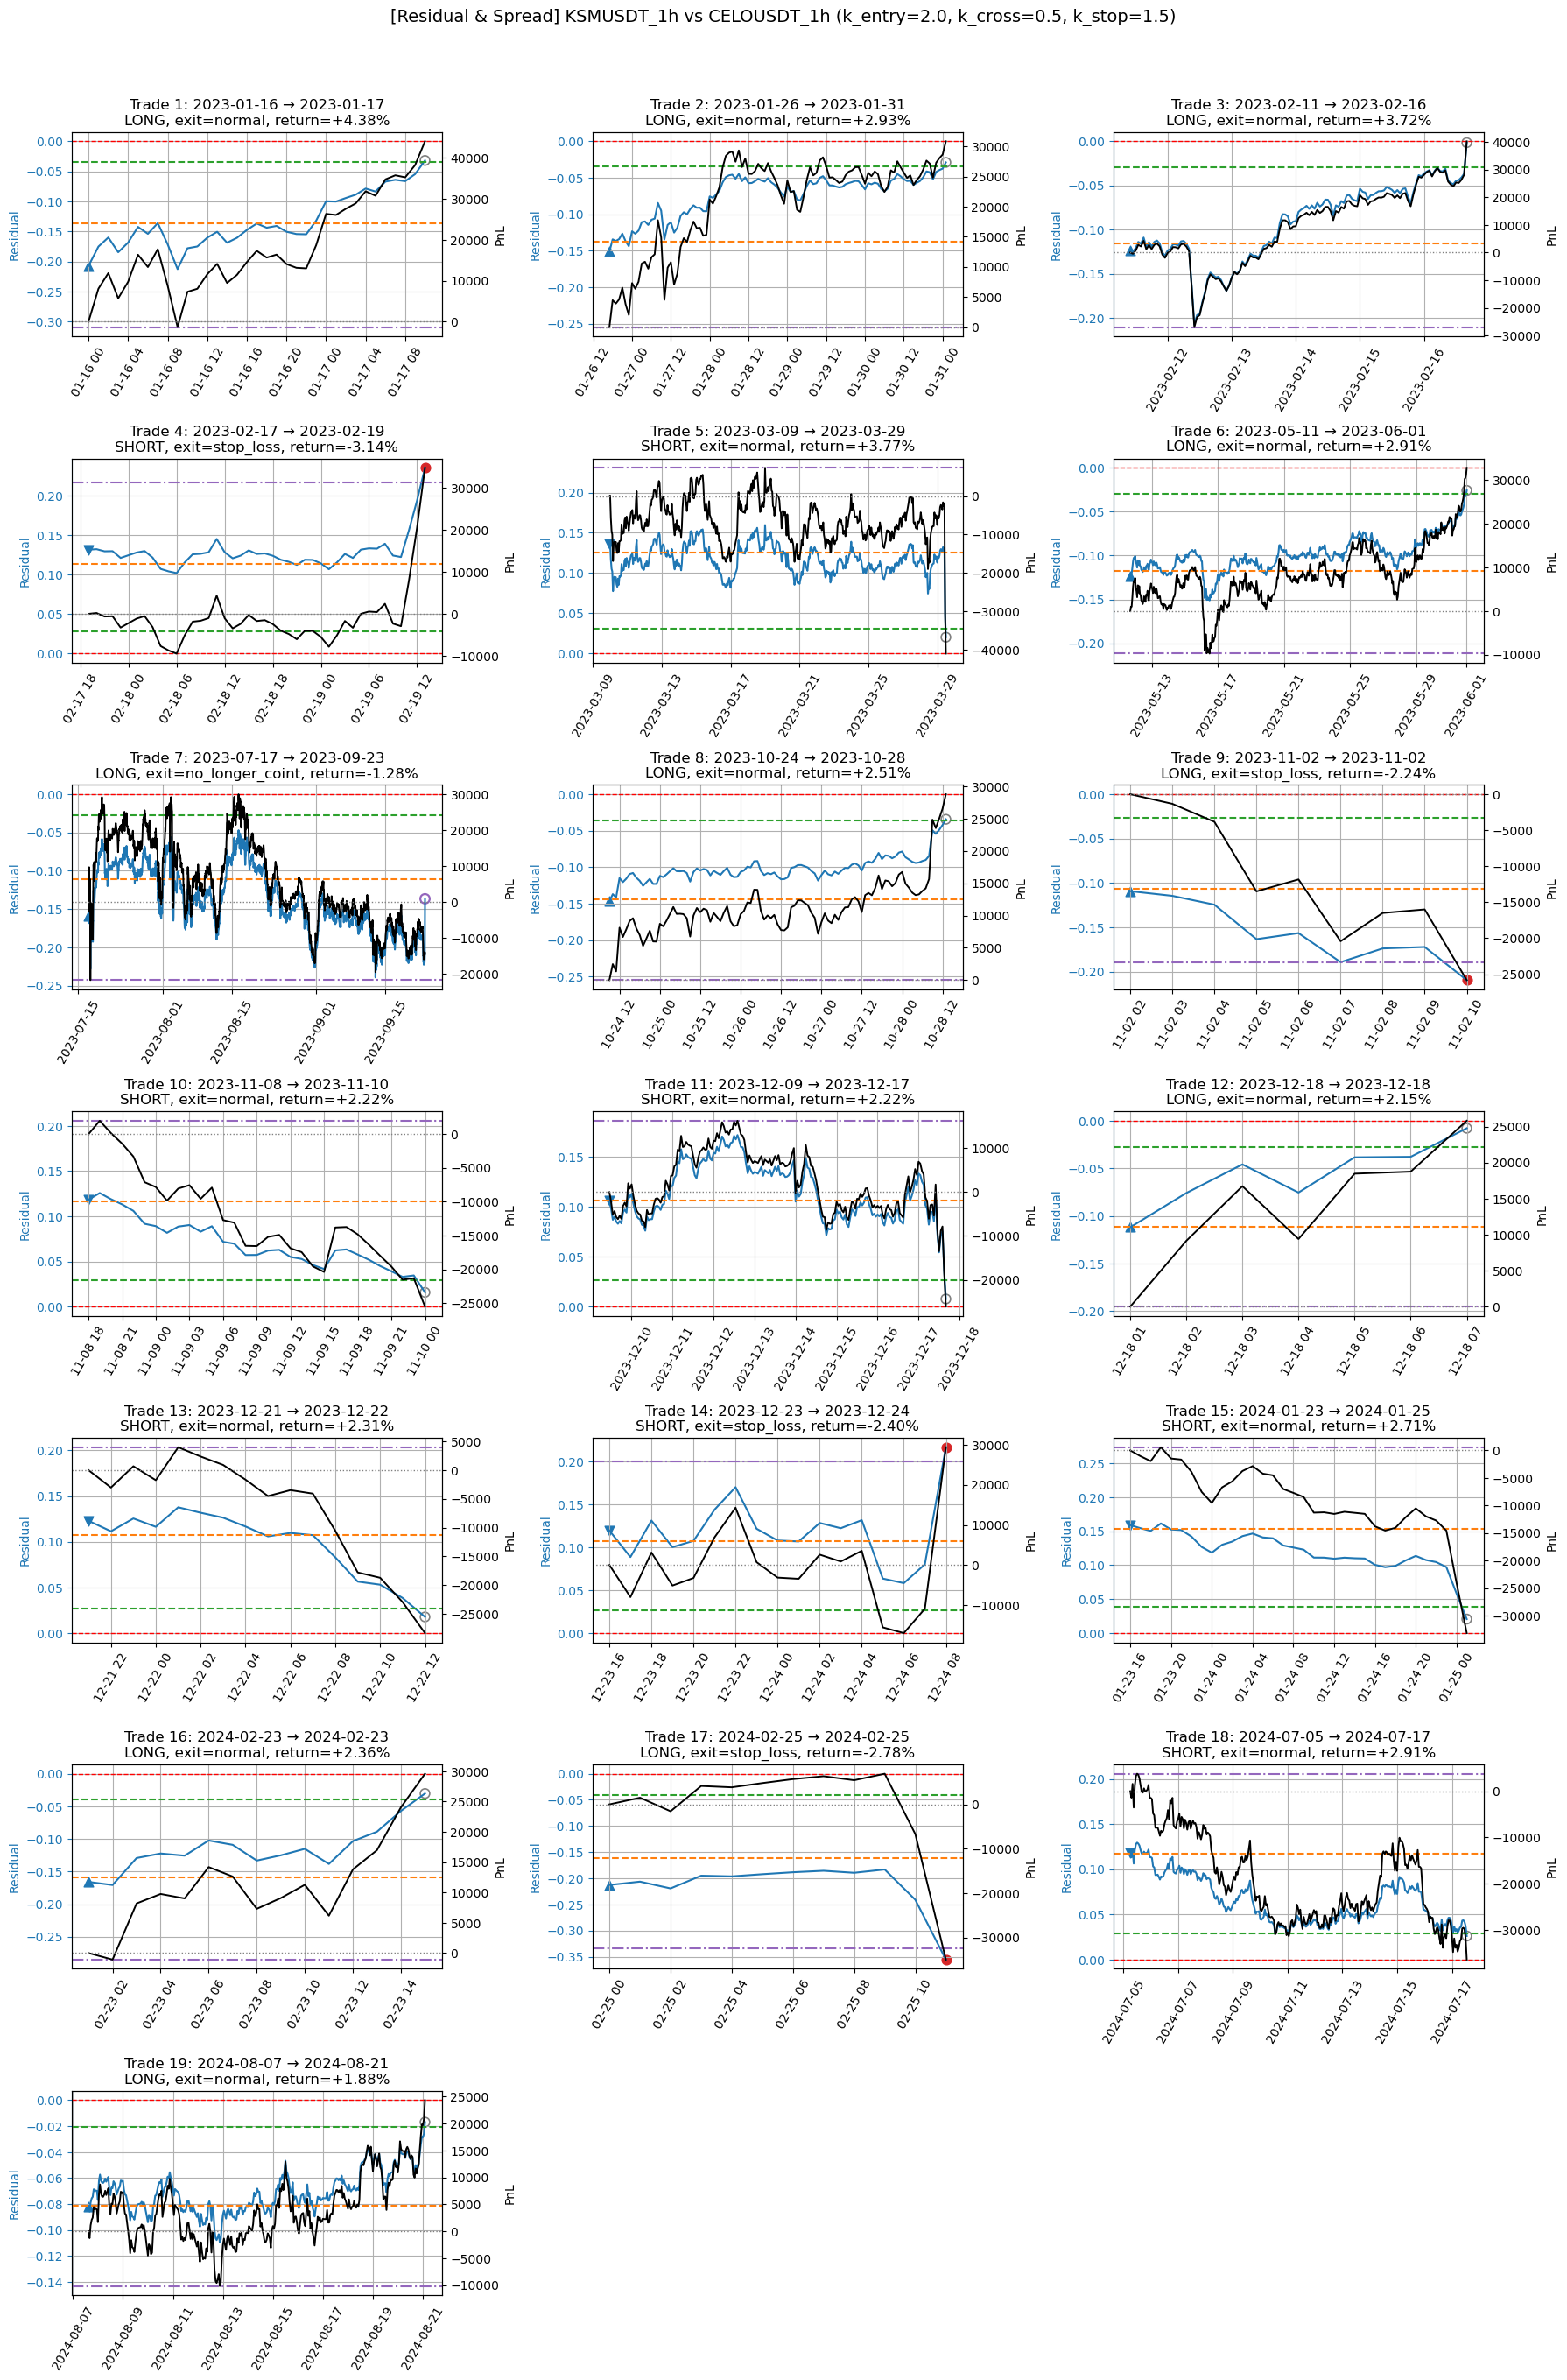

In [13]:
plot_beta_and_pvalue(daily, title=f"Beta & P-Value {key1} vs {key2}")

plot_equity_with_trades(daily, title=f"Backtest {key1} vs {key2}")

plot_trade_residual_spread_paths(
    daily,
    prices_df=merged_df[["open_time", "close_1", "close_2"]],
    entry_k=bt.entry_k,
    exit_cross_k=bt.exit_k,
    stop_k=bt.stop_k,
    max_trades=None,
    title_prefix=f"[Residual & Spread] {key1} vs {key2}",
)

In [6]:
# Grid search helpers
bars_per_day = 24
INITIAL_BAL = 1_000_000.0
FIG_ROOT = Path("figures")
FIG_ROOT.mkdir(exist_ok=True)
prices_for_plots = merged_df[["open_time", "close_1", "close_2"]]


def run_once_return_daily(
    train_len_days: int, entry_k: float, gap_bars: int = 24
) -> tuple[pd.DataFrame, pd.DataFrame, CointBacktester]:
    bt = CointBacktester(
        exchange=ex,
        start_time=start,
        end_time=end,
        coint_var=coint_var,
        train_len=int(train_len_days * bars_per_day),
        gap=gap_bars,
        pval_alpha=0.05,
        entry_k=entry_k,
        exit_k=0.5,
        relaxed_pval_alpha=0.20,
        stop_k=1.5,
        stop_loss_cooling_days=5.0,
        initial_balance=INITIAL_BAL,
        trade_frac=0.05,
        margin_rate=0.10,
        fee_rate=5e-4,
    )
    daily_i, fits_i = bt.run()
    return daily_i, fits_i, bt


def _safe_float(value: object) -> float:
    try:
        if value is None:
            return float("nan")
        val = float(value)
        return val if np.isfinite(val) else float("nan")
    except (TypeError, ValueError):
        return float("nan")


def _trade_metrics(daily_df: pd.DataFrame) -> dict[str, float]:
    segs = _trade_segments_from_daily(daily_df)
    n_trades = len(segs)

    entry_flags = daily_df.get("entry_flag", pd.Series(False, index=daily_df.index))
    entry_count = int(entry_flags.astype(bool).sum())

    durations = []
    normal_count = 0
    for seg in segs:
        entry_time = pd.to_datetime(seg.get("entry_time"))
        exit_time = pd.to_datetime(seg.get("exit_time"))
        if pd.notna(entry_time) and pd.notna(exit_time):
            delta_days = (exit_time - entry_time).total_seconds() / (24 * 3600.0)
            durations.append(delta_days)
        if (seg.get("exit_reason") or "normal") == "normal":
            normal_count += 1

    avg_days = float(np.mean(durations)) if durations else float("nan")
    median_days = float(np.median(durations)) if durations else float("nan")
    success_pct = normal_count / n_trades if n_trades else float("nan")

    return {
        "n_trades": n_trades,
        "avg_revert_days": avg_days,
        "median_revert_days": median_days,
        "normal_exit_pct": success_pct,
        "entry_count": entry_count,
    }


def _combo_slug(train_len_days: int, entry_k: float) -> str:
    return f"train_{train_len_days:03d}_entry_{entry_k:.1f}".replace(".", "p")


train_lens_days = list(range(30, 121, 30))
entry_ks = [round(x, 1) for x in np.arange(1.0, 3.0 + 1e-9, 0.5)]

grid_rows: list[dict] = []
for tl in tqdm(train_lens_days, desc="train_len_days"):
    for ek in tqdm(entry_ks, desc=f"entry_k (train={tl}d)", leave=False):
        daily_i, fits_i, bt_i = run_once_return_daily(train_len_days=tl, entry_k=ek, gap_bars=24)

        try:
            perf_i, _ = summarize_performance(daily_i, pnl_col="pnl", time_col="time")
        except Exception:
            perf_i = {}

        stats = _trade_metrics(daily_i)

        final_equity = float(daily_i["pnl"].iloc[-1]) if len(daily_i) else float("nan")
        final_pnl = final_equity - INITIAL_BAL
        ret_pct = _safe_float(perf_i.get("Ret")) if perf_i else (
            final_pnl / INITIAL_BAL if np.isfinite(final_pnl) else float("nan")
        )

        combo_dir = FIG_ROOT / _combo_slug(tl, ek)
        combo_dir.mkdir(parents=True, exist_ok=True)
        title_suffix = f"train={tl}d | entry_k={ek:.1f}"

        plot_equity_with_trades(
            daily_i,
            title=f"Backtest {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "equity.png"),
        )
        plot_beta_and_pvalue(
            daily_i,
            title=f"Beta & P-Value {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "beta_pvalue.png"),
        )
        plot_trade_residual_spread_paths(
            daily_i,
            prices_df=prices_for_plots,
            entry_k=bt_i.entry_k,
            exit_cross_k=bt_i.exit_k,
            stop_k=bt_i.stop_k,
            max_trades=None,
            title_prefix=f"[Residual & Spread] {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "residual_spread.png"),
        )

        grid_rows.append(
            {
                "train_len_days": tl,
                "entry_k": ek,
                **stats,
                "final_equity": final_equity,
                "final_pnl": final_pnl,
                "return_pct": ret_pct,
                "ann_ret": _safe_float(perf_i.get("AnnRet")) if perf_i else float("nan"),
                "ann_vol": _safe_float(perf_i.get("AnnVol")) if perf_i else float("nan"),
                "sharpe": _safe_float(perf_i.get("Sharpe")) if perf_i else float("nan"),
                "max_drawdown": _safe_float(perf_i.get("MaxDrawdown")) if perf_i else float("nan"),
            }
        )

results_df = (
    pd.DataFrame(grid_rows)
    .sort_values("sharpe", ascending=False, na_position="last")
    .reset_index(drop=True)
)
results_df

train_len_days: 100%|██████████| 4/4 [13:51<00:00, 207.94s/it]


,train_len_days,entry_k,n_trades,avg_revert_days,median_revert_days,normal_exit_pct,entry_count,final_equity,final_pnl,return_pct,ann_ret,ann_vol,sharpe,max_drawdown
0,120,1.0,68,3.280637,1.291667,0.823529,68,1.414656e+06,414655.758757,0.414656,0.189818,0.102033,1.754270,-0.094775
1,120,2.0,19,8.642544,1.750000,0.736842,19,1.296343e+06,296343.029503,0.296343,0.138875,0.086157,1.552333,-0.046407
2,60,2.0,29,4.316092,2.916667,0.655172,29,1.260487e+06,260487.001593,0.260487,0.113120,0.080583,1.370100,-0.057471
3,120,1.5,35,4.970238,2.625000,0.742857,35,1.272379e+06,272378.886518,0.272379,0.128277,0.093602,1.336155,-0.096094
4,60,2.5,19,4.296053,2.125000,0.578947,19,1.167605e+06,167605.394182,0.167605,0.074368,0.062176,1.184685,-0.041648
5,60,3.0,11,4.534091,3.708333,0.454545,11,1.118010e+06,118009.645616,0.118010,0.052996,0.058463,0.912435,-0.084397
6,90,1.0,74,3.432995,1.708333,0.716216,74,1.201312e+06,201312.406514,0.201312,0.092276,0.109198,0.862869,-0.115043
7,90,2.0,19,8.535088,3.166667,0.631579,19,1.170646e+06,170645.595437,0.170646,0.078768,0.093562,0.857126,-0.088706
8,90,3.0,8,10.796875,5.291667,0.500000,8,1.113484e+06,113483.629288,0.113484,0.053090,0.063221,0.849766,-0.059357
9,90,2.5,13,9.567308,6.541667,0.538462,13,1.125735e+06,125734.709861,0.125735,0.058650,0.077439,0.774687,-0.096065


<Axes: title={'center': 'Sharpe heatmap'}, xlabel='entry_k', ylabel='train_len_days'>

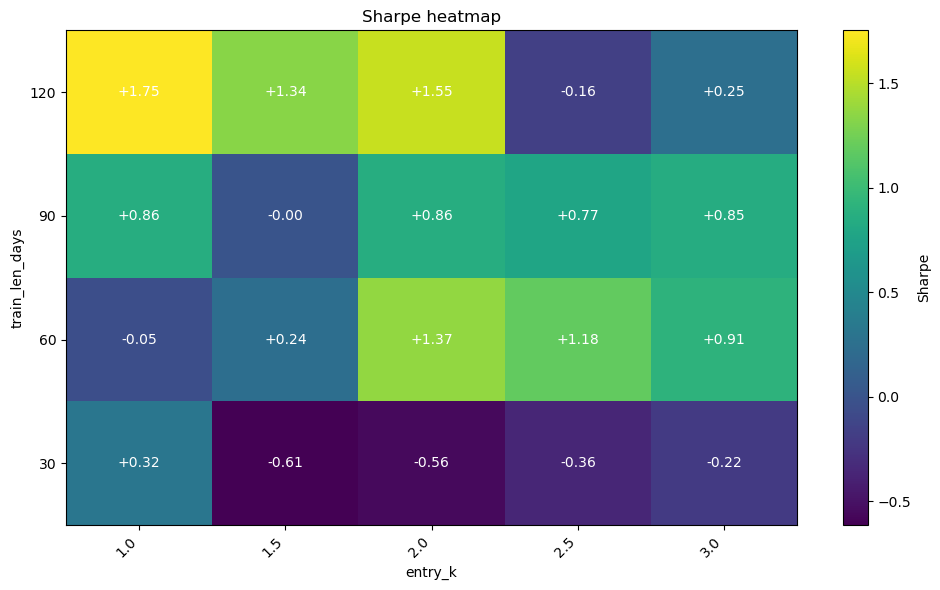

In [7]:
heatmap_from_results(
    results_df,
    metric_col="sharpe",
    title="Sharpe heatmap",
    cbar_label="Sharpe",
    fmt="{:+.2f}",
    mask_nan=True,
)

<Axes: title={'center': 'Final equity heatmap'}, xlabel='entry_k', ylabel='train_len_days'>

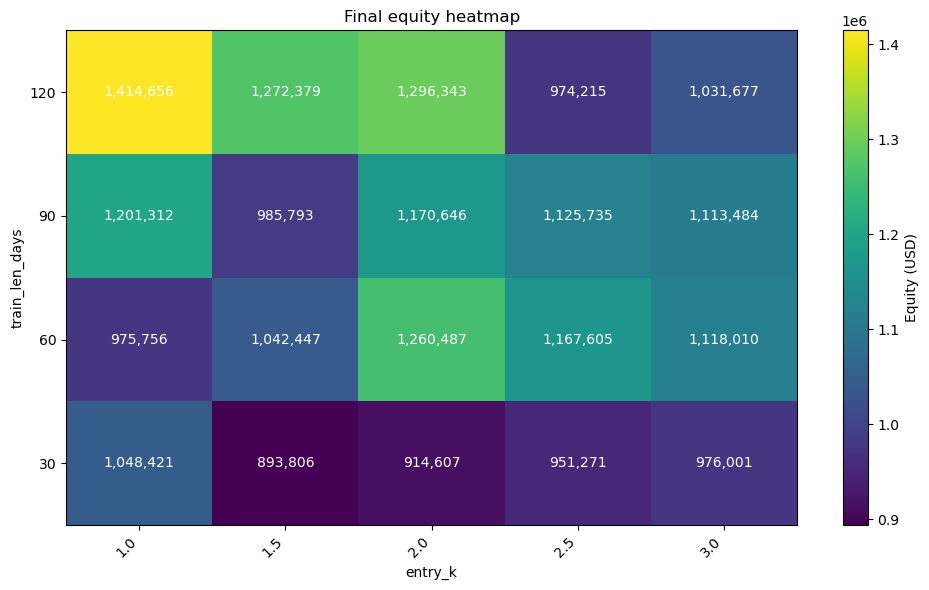

In [8]:
heatmap_final_equity(
    results_df,
    title="Final equity heatmap",
    cbar_label="Equity (USD)",
    fmt="{:,.0f}",
)

<Axes: title={'center': 'Success rate heatmap'}, xlabel='entry_k', ylabel='train_len_days'>

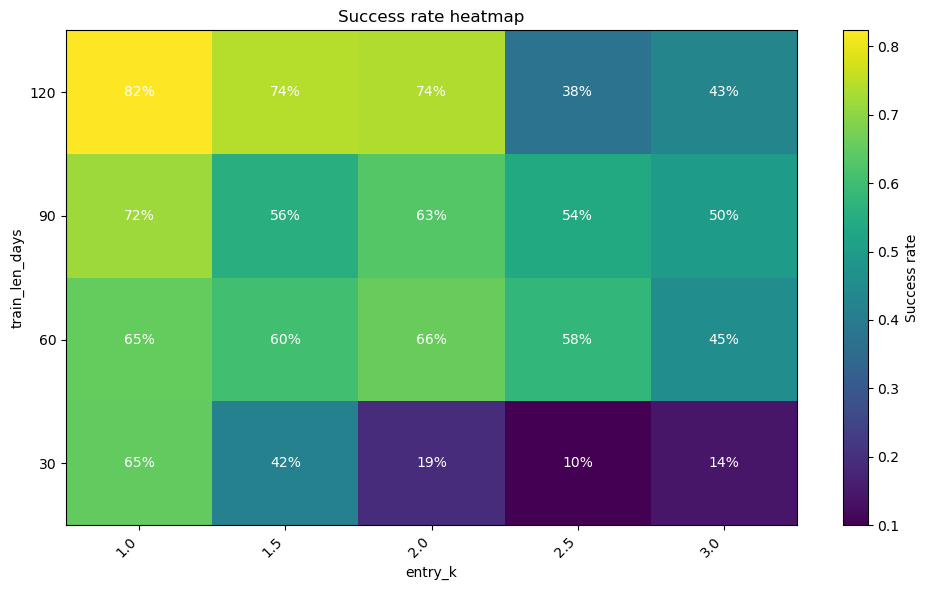

In [9]:
heatmap_success_rate(
    results_df,
    metric_col="normal_exit_pct",
    title="Success rate heatmap",
    cbar_label="Success rate",
    fmt="{:.0%}",
)

<Axes: title={'center': 'Entry count heatmap'}, xlabel='entry_k', ylabel='train_len_days'>

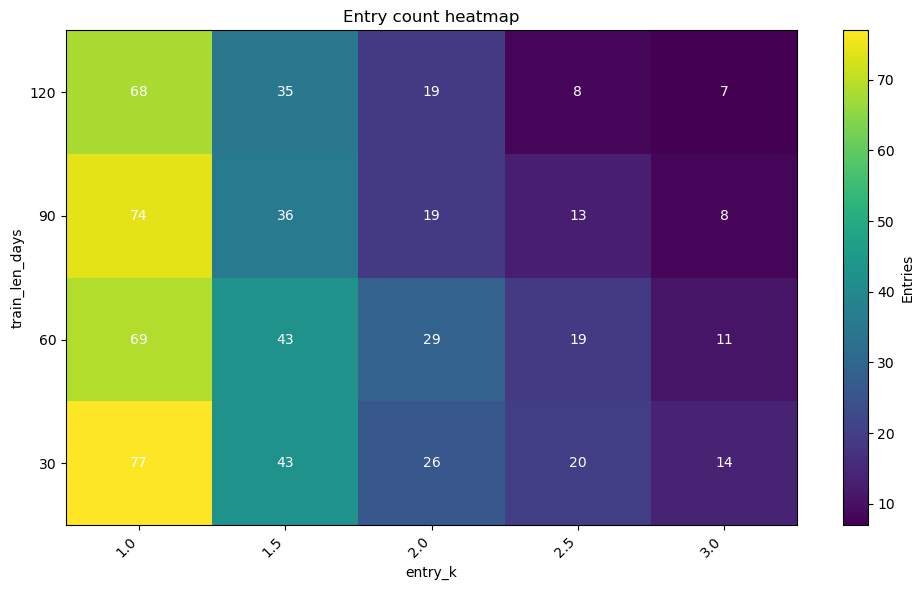

In [10]:
heatmap_entry_count(
    results_df,
    metric_col="entry_count",
    title="Entry count heatmap",
    cbar_label="Entries",
    fmt="{:.0f}",
)

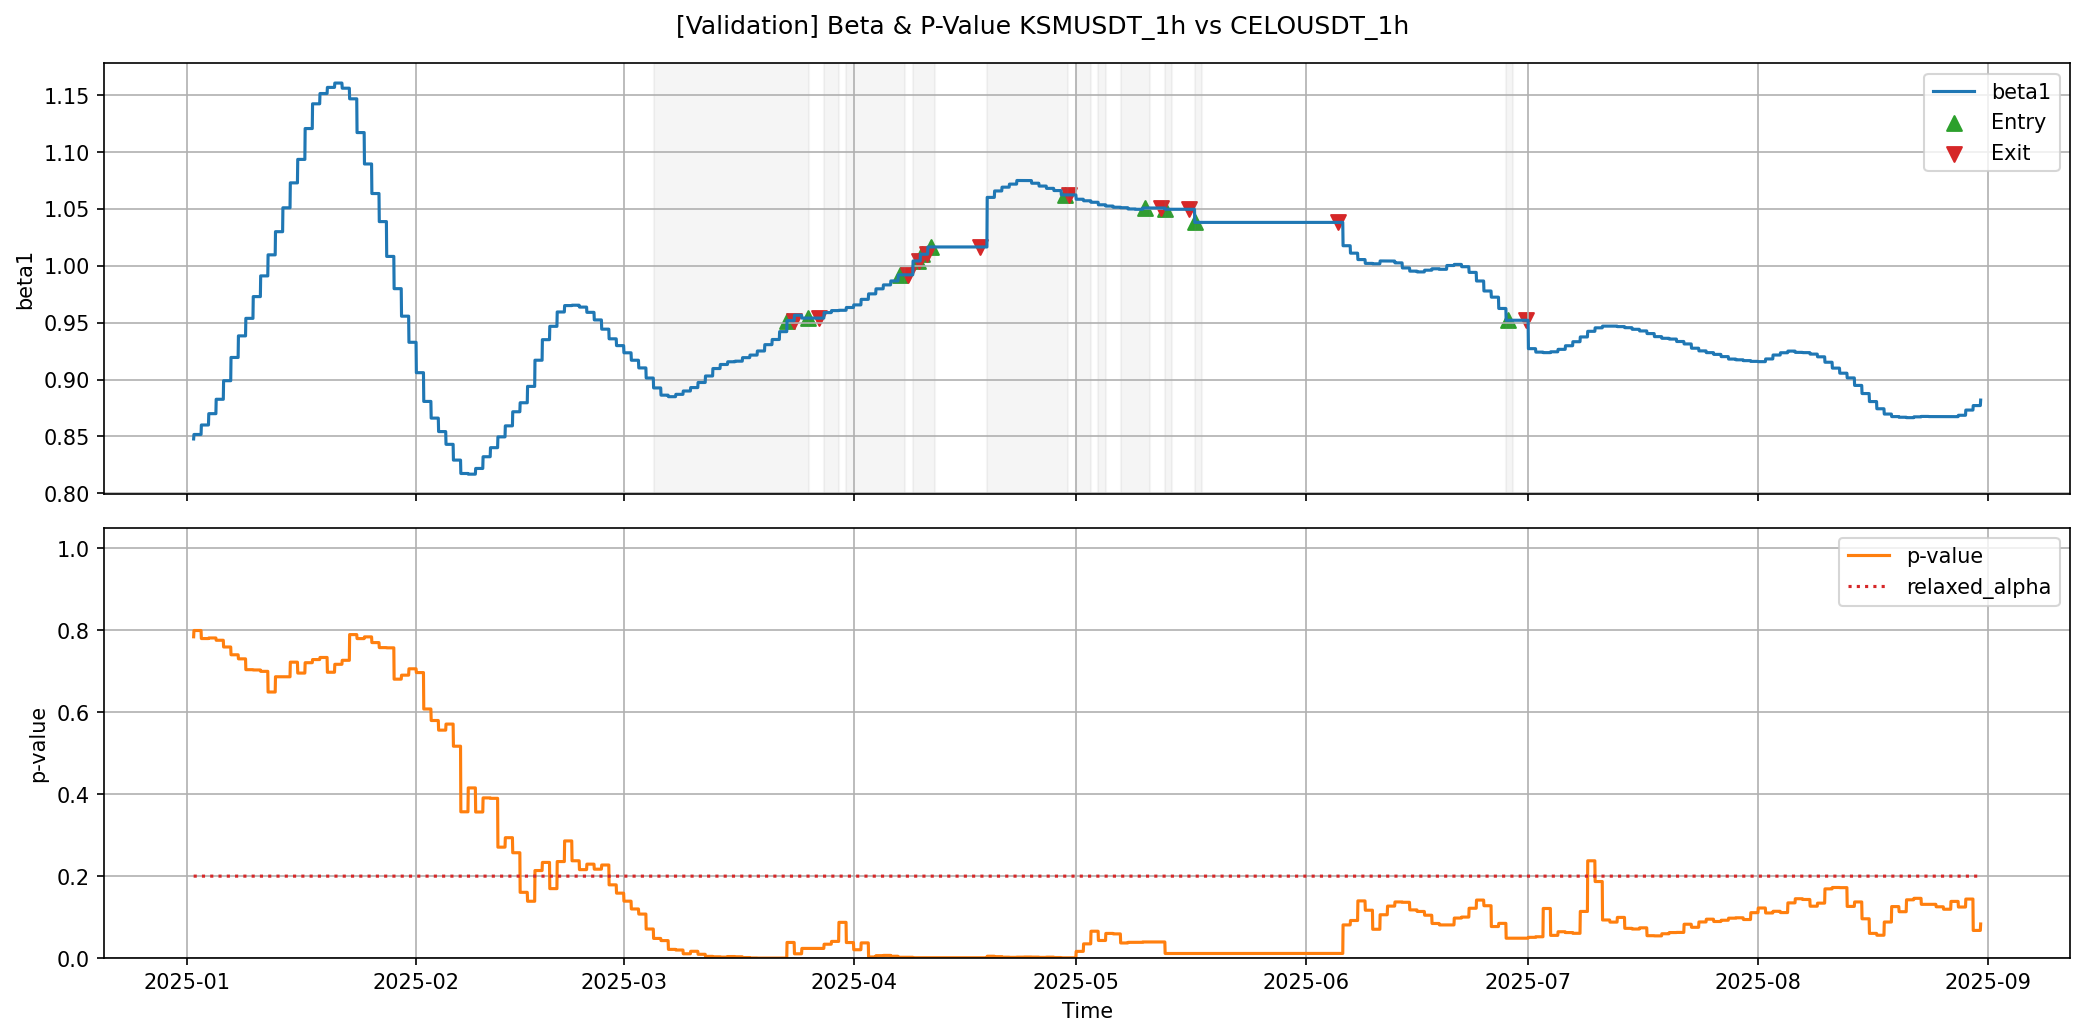

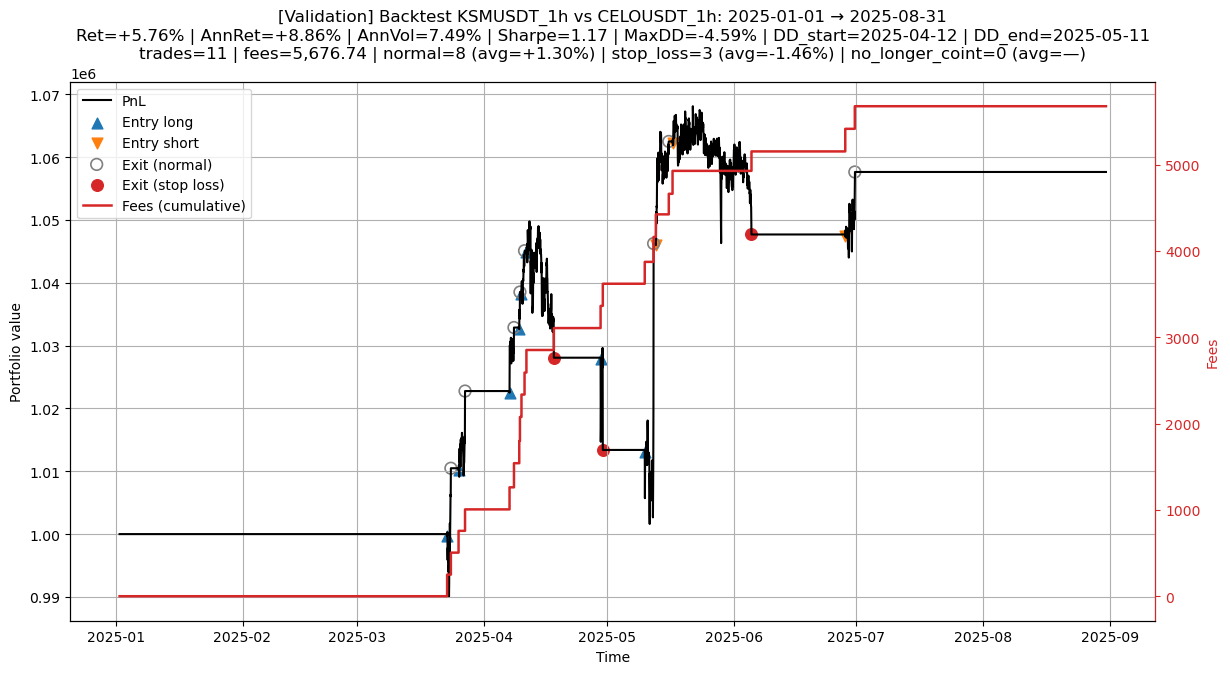

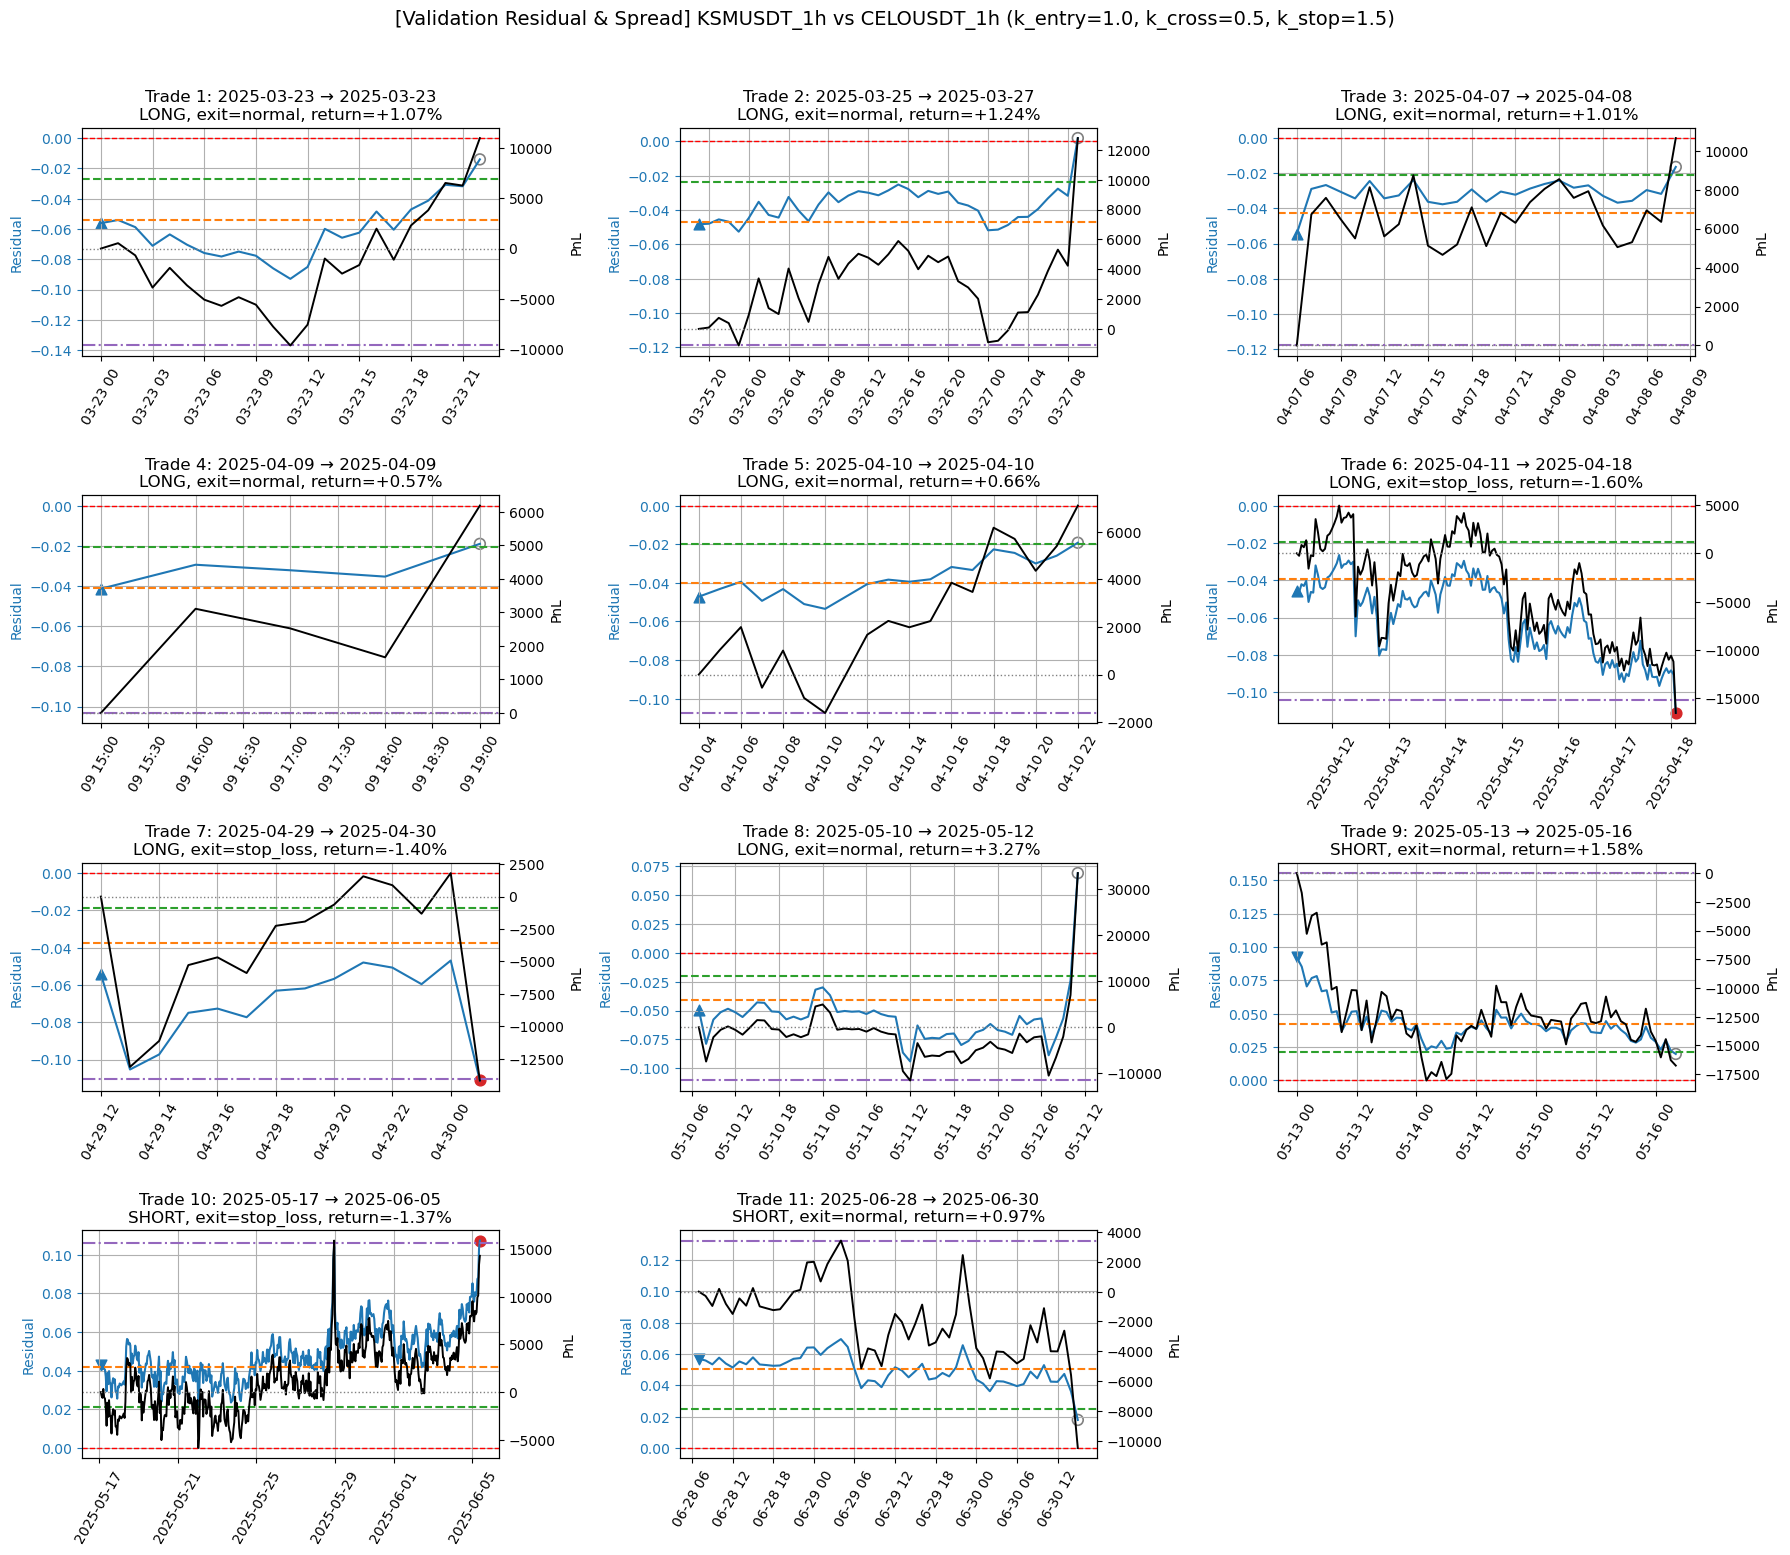

In [16]:
start_date = (datetime(2025, 1, 1) - timedelta(days=120)).strftime("%Y-%m-%d")
end_date = "2025-08-31"

df_dict_val = load_crypto_dir(data_dir, start_date=start_date, end_date=end_date)

df1_val = preprocess_ohlc(df_dict_val[key1])
df2_val = preprocess_ohlc(df_dict_val[key2])
merged_val = align_two(df1_val, df2_val, coint_var=coint_var)

ex_val = Exchange(merged_val, coint_var=coint_var)
start_val = merged_val["open_time"].min()
end_val = merged_val["open_time"].max()

bt_val = CointBacktester(
    exchange=ex_val,
    start_time=start_val,
    end_time=end_val,
    coint_var=coint_var,
    train_len=120 * 24,
    gap=24,
    pval_alpha=0.05,
    entry_k=1.0,
    exit_k=0.5,
    relaxed_pval_alpha=0.20,
    stop_k=1.5,
    stop_loss_cooling_days=5.0,
    initial_balance=INITIAL_BAL,
    trade_frac=0.05,
    margin_rate=0.10,
    fee_rate=5e-4,
)

daily_val, fits_val = bt_val.run()

plot_beta_and_pvalue(daily_val, title=f"[Validation] Beta & P-Value {key1} vs {key2}")
plot_equity_with_trades(daily_val, title=f"[Validation] Backtest {key1} vs {key2}")
plot_trade_residual_spread_paths(
    daily_val,
    prices_df=merged_val[["open_time", "close_1", "close_2"]],
    entry_k=bt_val.entry_k,
    exit_cross_k=bt_val.exit_k,
    stop_k=bt_val.stop_k,
    title_prefix=f"[Validation Residual & Spread] {key1} vs {key2}",
)